In [1]:
import os
import h5py
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.sparse.linalg import svds
from numpy import linalg as la
import datetime
import numpy as np
import obspy
from obspy.signal.filter import bandpass,lowpass


In [2]:
def flip_signs(A, B):
    """
    utility function for resolving the sign ambiguity in SVD
    http://stats.stackexchange.com/q/34396/115202
    """
    signs = np.sign(A) * np.sign(B)
    return A, B * signs

In [3]:
def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    days1970 = datetime.date(1970, 1, 1).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)

    return thisDateTime

In [4]:
def data_wrangler(cable,record_length,t0):
    if cable == 'seadasn':
        prefix = 'seadasn'
        network_name = 'SeaDAS-N'
        if t0 < datetime.datetime(2022, 6, 20, 0, 0, 0):
            datastore='/data/data0/seadasn_2022-03-17_2022-06-20/'
        else:
            datastore='/data/data7/seadasn/'

    elif cable == 'whidbey':
        prefix = 'whidbey'
        network_name='Whidbey-DAS'
        if t0 < datetime.datetime(2022,10,23,4,50,0):
            datastore = '/data/data5/Converted/'
        else:
            datastore = '/data/data6/whidbey'
            
    return prefix, network_name, datastore

In [5]:
filename = '/data/data5/Converted/whidbey_2022-09-08_08-08-00_UTC_023814.h5'
data_file = h5py.File(filename)
# data= data_file['/Acquisition/Raw[0]/RawData'][:,2430:3315]
data= data_file['/Acquisition/Raw[0]/RawData']
time = np.array(data_file['Acquisition/Raw[0]/RawDataTime'])
times = sintela_to_datetime(time)
attrs=dict(data_file['Acquisition'].attrs)
samp_int = attrs['SpatialSamplingInterval']
fs = attrs['PulseRate']
chans = attrs['NumberOfLoci']
chans = np.r_[1:chans+1]

In [6]:
def pre_process(arr,fs,fmin,fmax):
    data = []
    st = obspy.Stream()
    if arr.ndim == 2:
        axis = 1
        for i in range(len(arr)):
            tr = obspy.Trace(data=arr[i,:])
            tr.stats.sampling_rate = fs
            st += tr
            del tr
    else:
        axis = 0
        tr = obspy.Trace(data=arr)
        tr.stats.sampling_rate = fs
        st += tr
        del tr
    st.detrend('constant')
    st.detrend('linear')
    percent = percent = np.min([fs * 3 / arr.shape[axis],0.05])
    st.taper(max_percentage=percent)
    st.filter('bandpass',freqmin=fmin,freqmax=fmax,zerophase=True)
    for tr in st:
        data.append(tr.data)
    data = np.array(data)
    if data.shape[0] == 1:
        data = data.flatten()
    return data

In [7]:
def do_svd(data,method='standard'):
    
    if method == 'sparse':
        nt,nx = data.shape
        
        U,S,V = svds(data)
        S=np.diag(S,k=6)
#         if kmin is None:
#             k = len(np.where(np.diag(S) >= 1)[0])
        
        U0 = np.array(U[:,:k]).reshape((nt,k))
        V0 = np.array(V[:k,:]).reshape((k,nx))
        S0 = S[:k,:k]

        reconstruction = U0.dot(S0).dot(V0)
        return reconstruction, k, U, S, V, U0,V0,S0
    
    if method == 'standard':
        n,m = data.shape
        # the m x m covariance matrix
        C = np.cov(data, rowvar=False)
#         C = np.dot(data.T, data) / (n-1)
        # C is a symmetric matrix and so it can be diagonalized:
        lamda, principal_axes = la.eigh(C)
        # sort results wrt. eigenvalues
        idx = lamda.argsort()[::-1]
        lamda, principal_axes = lamda[idx], principal_axes[:, idx]

        # projections of data on the principal axes are called principal components
        principal_components =data.dot(principal_axes)
#         print(f'PCs = \n {principal_components}')
        
        U,s,Vt = la.svd(data,full_matrices=False)
        V = Vt.T
        S = np.diag(s)
        
        # 8) dimensionality reduction
#         if kmin is None:
#             k = len(np.where(np.diag(S) >= 1)[0])
#         else:
#             k = len(np.where(np.diag(S) >= kmin)[0])
            
        # find number of PCs to explain >= 99%
        cmsm = np.cumsum(np.real(lamda))/np.sum(np.real(lamda))
        k = np.where(cmsm >= 0.995)[0][0]

        PC_k = principal_components[:, :k]
        US_k = U[:, :k].dot(S[:k, :k])

        # multiplying the first k PCs by the k princ axes V.T(k) yields a
        # X(k) = U(k)S(k)V.T(k) matrix that has the original n x m size but
        # lower rank (of rank k). This is the lowest possible reconstruction 
        # error 
        Xk = US_k.dot(Vt[:k, :])
        
        return k,PC_k,US_k,Vt,Xk,C,lamda

In [8]:
filt_data = pre_process(data,fs,0.1,10)
# reconstruction, k, U, S, V, U0,V0,S0 = do_svd(filt_data,num_sv=15)
k,PC_k,US_k,Vt,Xk,C,lamda = do_svd(filt_data)

<IPython.core.display.Javascript object>


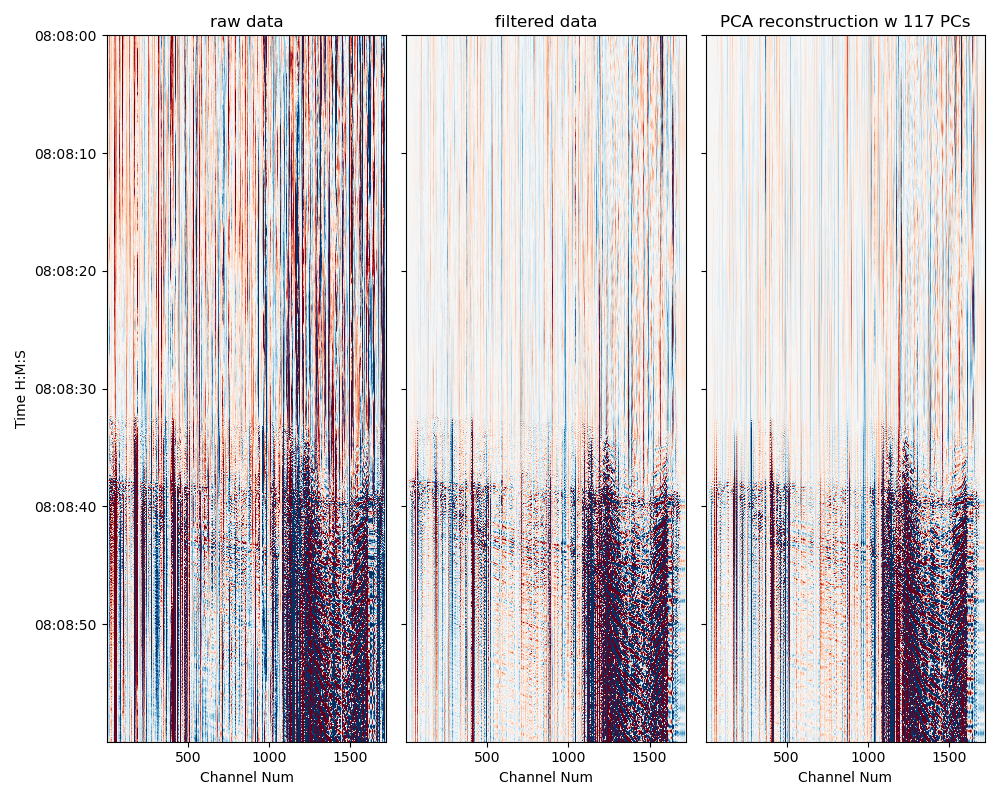

In [9]:

fig,ax = plt.subplots(1,3,figsize=(10,8),sharex=True,sharey=True)
vmin = -3
vmax = 3

ax[0].pcolormesh(chans,times,data,vmin=vmin,vmax=vmax,cmap='RdBu')
ax[0].title.set_text('raw data')
ax[0].set_xlabel('Channel Num')
ax[0].set_ylabel('Time H:M:S')

ax[1].pcolormesh(chans,times,filt_data,vmin=vmin,vmax=vmax,cmap='RdBu')
ax[1].title.set_text('filtered data')
ax[1].set_xlabel('Channel Num')


ax[2].pcolormesh(chans,times,Xk,vmin=vmin,vmax=vmax,cmap='RdBu')
ax[2].title.set_text(f'PCA reconstruction w {k} PCs')
ax[2].set_xlabel('Channel Num')

fig.tight_layout()
fig.gca().invert_yaxis()
plt.show()
# plt.savefig('Whidbey_pca.png', bbox_inches='tight')

In [ ]:
np.savez_compressed('data_compressed',US_k,Vt[:k,:])

In [10]:
origsize = os.path.getsize('/data/data5/Converted/whidbey_2022-09-08_08-08-00_UTC_023814.h5')/1e6
compsize = os.path.getsize('/home/dpsprink/data/mlGeo/data_compressed.npz')/1e6

In [18]:
print(f'File size {origsize} MB')

File size 41.44424 MB


In [19]:
print(f'File size {compsize} MB')

File size 6.98591 MB


In [20]:
print(f' Compression ratio {round(origsize/compsize)} : 1')
print(f' Space saving percent ~ {100-round(compsize/origsize*100)} % ')

 Compression ratio 6 : 1
 Space saving percent ~ 83 % 


<IPython.core.display.Javascript object>


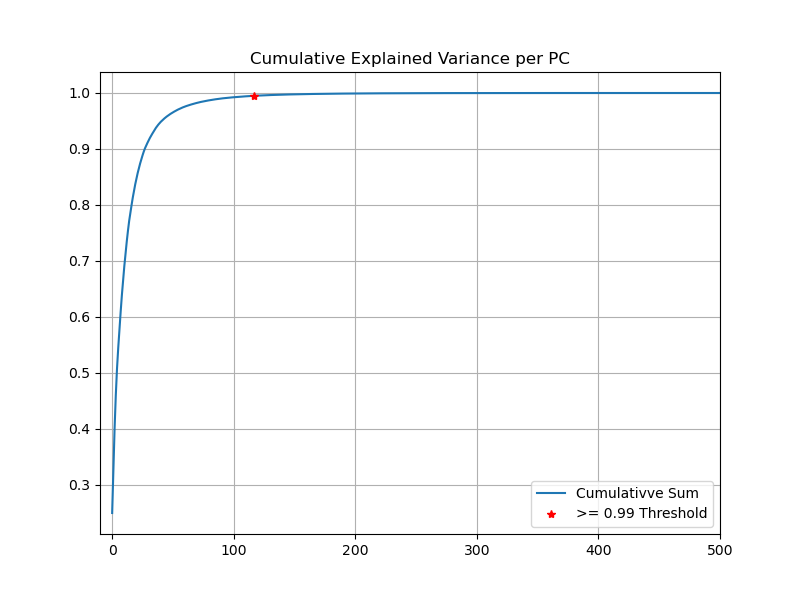

In [21]:
cmsm = np.cumsum(np.real(lamda))/np.sum(np.real(lamda))
indx = np.where(cmsm > 0.995)[0][0]
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(cmsm,label='Cumulativve Sum')
ax.plot(indx,cmsm[indx],'*r',label='>= 0.99 Threshold')
ax.set_xlim(-10,500)
ax.grid()
ax.set_title('Cumulative Explained Variance per PC')
ax.legend()
plt.savefig('explainedVar.png', bbox_inches='tight')